<a href="https://colab.research.google.com/github/brobro10000/CS5262-foundations-of-machine-learning/blob/main/HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network In Pytorch
This assignment aims to get familiarized with building the whole pipeline of deep learning in Pytorch to perform classification and test it out on the CIFAR-10 dataset. All the code will be implemented in this notebook.

In [66]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [67]:
%cd gdrive/MyDrive/Colab\ Notebooks/hw10

[Errno 2] No such file or directory: 'gdrive/MyDrive/Colab Notebooks/hw10'
/content/gdrive/MyDrive/Colab Notebooks/hw10


First, let's install modules not already installed by Google Colab.

In [68]:
!pip install torch_utils

## Task 1: Design the Neural Network and Data Preparation


In the beginning, please import all the packages you need. We provide some packages here, which might be helpful when you build your code.

In [69]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf


from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np

import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

###Network Design
Then, we need to define a class for your network. The network should include two linear layer, one Relu layer, and one dropout layer.

In [70]:
# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        # Define all the layers that you need in your network
        # You can use nn.Linear() to define the linear layer
        # You can use nn.Dropout() to define the dropout layer
        # You can use F.relu() to define your ReLu layer
        ######################
        ### YOUR CODE HERE ###
        ######################
        self.fc1 = nn.Linear(input_d, hidden_d)
        self.fc2 = nn.Linear(hidden_d, output_d)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        #####################
        ### YOUR CODE END ###
        #####################

    def forward(self, x):
        # Design your network structure here
        ######################
        ### YOUR CODE HERE ###
        ######################
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        #####################
        ### YOUR CODE END ###
        #####################

Now, we can design our toy model to test your network.

In [71]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return bmodel(input_size, hidden_size, num_classes)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

toy_model = init_toy_model()
train_X, train_Y = init_toy_data()
validation_X, validation_Y = init_toy_data()

Cuda is Compute Unified Device Architecture, which can achieve parallel computing. It will improve our learning speed in the parameter update by using GPU rather than CPU.

In [72]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


###Data Preparation
Next, we need to organize the data before we load them into the network. In Pytorch, we use Tensor as the data structure for computing, and we use "dataloaders" to achieve mini-batch from the whole dataset.

In [73]:
# Datasets organization
batch_size = 1

# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_Y).float()),
    'valid':
    # please define your validation dataset
    ######################
    ### YOUR CODE HERE ###
    ######################
    TensorDataset(torch.from_numpy(validation_X), torch.from_numpy(validation_Y).float())
    #####################
    ### YOUR CODE END ###
    #####################

}


# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid':
    # please define your validation data loader
    ######################
    ### YOUR CODE HERE ###
    ######################
    DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10)
    ######################
    ### YOUR CODE END ####
    ######################
}



# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape


(torch.Size([1, 4]), torch.Size([1]))

### Setting Learning Parameters
In our training process, we need to set up the loss function and optimizer tool.

In [74]:
# Set up your criterion and optimizer
# You can use nn.CrossEntropyLoss() and optim.Adam()
#####################
### YOUR CODE HERE###
#####################
criterion = nn.CrossEntropyLoss()
# We only pass parameters that require a gradient
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, toy_model.parameters()),
    lr=0.001
)
####################
### YOUR CODE END###
####################

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([10, 4])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


## Task 2: Build the Training Pipeline

### Training Process
We are now defining the train function. Please follow the instruction to finish each part.

In [75]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu, both model parameters, data, and target need to be tensors.
            # You can use .cuda() function
            ######################
            ### YOUR CODE HERE ###
            ######################
            # Move data and model to GPU with correct dtype
            data = data.cuda().float()
            target = target.cuda().long()
            model = model.cuda()

            #####################
            ### YOUR CODE END ###
            #####################

            # Clear gradients
            optimizer.zero_grad()

            # Forward path
            ######################
            ### YOUR CODE HERE ###
            ######################
            output = model(data)
            #####################
            ### YOUR CODE END ###
            #####################

            # Loss function
            ######################
            ### YOUR CODE HERE ###
            ######################
            loss = criterion(output, target)
            #####################
            ### YOUR CODE END ###
            #####################

            # Backward path (backpropagation)
            ######################
            ### YOUR CODE HERE ###
            ######################
            loss.backward()
            #####################
            ### YOUR CODE END ###
            #####################

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    data = data.cuda().float()
                    target = target.cuda().long()
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Forward path
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    output = model(data)
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Validation loss computation
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    loss = criterion(output, target)
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)


                # Calculate average losses and Calculate average accuracy
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    # You can use torch.save()
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    torch.save(model.state_dict(), save_file_name)
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        # You can use model.load_state_dict()
                        ######################
                        ### YOUR CODE HERE ###
                        ######################
                        model.load_state_dict(torch.load(save_file_name))
                        #####################
                        ### YOUR CODE END ###
                        #####################

                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

## Task 3: Train the network

### Train a Network With Toy Data


Well done! Once we finish our train process design, we can start to train our network with our toy dataset.

In [76]:
from timeit import default_timer as timer
save_file_name = f'toy_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(toy_model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=500,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 2.3901 	Validation Loss: 1.6326
		Training Accuracy: 20.00%	 Validation Accuracy: 20.00%

Epoch: 1 	Training Loss: 1.8967 	Validation Loss: 1.5380
		Training Accuracy: 20.00%	 Validation Accuracy: 20.00%

Epoch: 2 	Training Loss: 1.1377 	Validation Loss: 1.4560
		Training Accuracy: 60.00%	 Validation Accuracy: 20.00%

Epoch: 3 	Training Loss: 1.5805 	Validation Loss: 1.3816
		Training Accuracy: 40.00%	 Validation Accuracy: 20.00%

Epoch: 4 	Training Loss: 1.3989 	Validation Loss: 1.3036
		Training Accuracy: 40.00%	 Validation Accuracy: 20.00%

Epoch: 5 	Training Loss: 0.9915 	Validation Loss: 1.2376
		Training Accuracy: 40.00%	 Validation Accuracy: 20.00%

Epoch: 6 	Training Loss: 1.0727 	Validation Loss: 1.1814
		Training Accuracy: 40.00%	 Validation Accuracy: 20.00%

Epoch: 7 	Training Loss: 1.1029 	Validation Loss: 1.1198
		Training Accuracy: 40.00%	 Validation Accuracy: 20.00%

Epoch: 8 	Training Loss: 1.3701 	Validation Lo

Now, we can check the losses and accuracy during the training.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

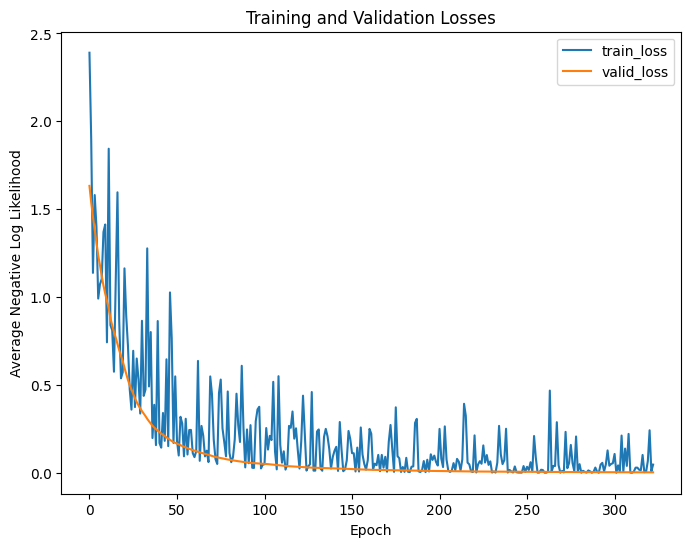

In [77]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

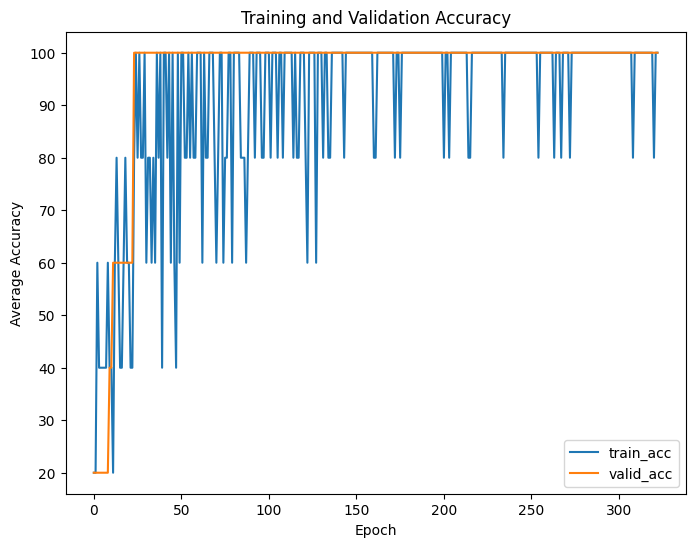

In [78]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

### Train a Network With Cifar-10 Data
Now we may use the cifar-10 dataset to train our model. First, we will load the cifar-10 dataset.

In [79]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './datasets/'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


Since Cifar-10 has a larger size of data, which is harder to train, we need to increase our network parameters to solve this task.


In [80]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

model = bmodel(input_size, hidden_size, num_classes)

Use the same chunk above to organize our new data. Now we may need a bigger batch_size for training.

In [81]:
# Datasets from folders
batch_size = 16
# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_Y).float()),
    'valid':
    ######################
    ### YOUR CODE HERE ###
    ######################
    TensorDataset(torch.from_numpy(validation_X), torch.from_numpy(validation_Y).float())
    #####################
    ### YOUR CODE END ###
    #####################

}


# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid':
    ######################
    ### YOUR CODE HERE ###
    ######################
    DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10)
    ######################
    ### YOUR CODE END ###
    ######################
}


# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([16, 3072]), torch.Size([16]))

Set up our criterion and optimizer for the new model.

In [82]:
# Set up your criterion and optimizer
######################
### YOUR CODE HERE ###
######################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#####################
### YOUR CODE END ###
#####################

Train your new network and get the results. At this time, the training process may need more time.

In [83]:
from timeit import default_timer as timer
save_file_name = f'cifar_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=500,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 8.4524 	Validation Loss: 2.0895
		Training Accuracy: 27.80%	 Validation Accuracy: 30.30%

Epoch: 1 	Training Loss: 3.0863 	Validation Loss: 3.8228
		Training Accuracy: 23.79%	 Validation Accuracy: 25.10%

Epoch: 2 	Training Loss: 3.5602 	Validation Loss: 3.3248
		Training Accuracy: 22.47%	 Validation Accuracy: 25.50%

Epoch: 3 	Training Loss: 3.7318 	Validation Loss: 3.2028
		Training Accuracy: 22.42%	 Validation Accuracy: 23.00%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 2.09 and acc: 23.00%
39.94 total seconds elapsed. 9.98 seconds per epoch.


It seems that the process will end very early since there is no progress during the training. Let's print the results.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

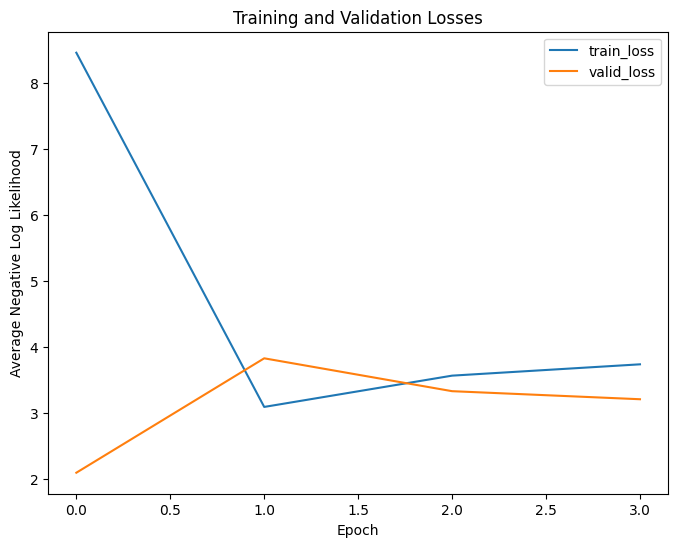

In [84]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

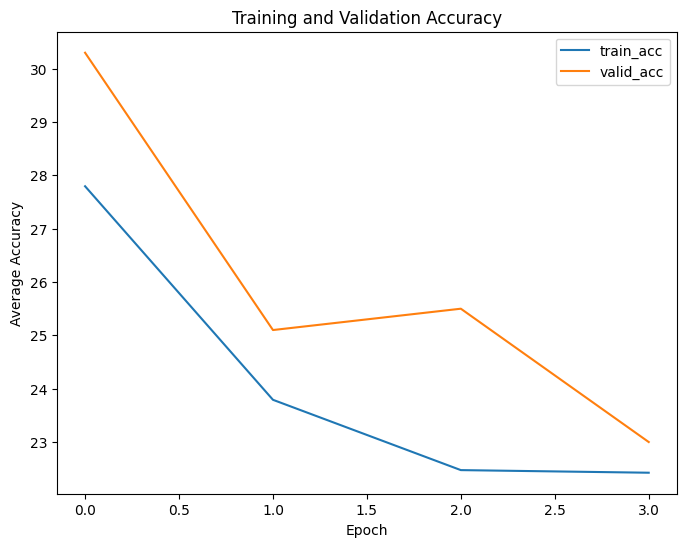

In [85]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

##Task 4: Improve The Performance
As we have known in HW2, a two-layer-network can not get a good performance. Here, we may (1) add more layers to make the network deeper, or (2) replace your bmodel() with networks provided by PyTorch. https://pytorch.org/vision/0.8/models.html
You just need to do one of these two options.

You can reuse the code you have from Task 2 and 3

In [86]:
######################
### YOUR CODE HERE ###
######################
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset and return it normalized and reshaped to [B, 3, 32, 32]
    """
    cifar10_dir = './datasets/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize to [0, 1] — required for CNNs to converge
    X_train = X_train.astype(np.float32) / 255.0
    X_val = X_val.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0

    # Apply per-channel normalization to [-1, 1] to improve stability
    # Without this change I was stuck at 7-10% accuracy with early stopping
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_test = (X_test - mean) / std

    # Reshape from NHWC → NCHW format (required by PyTorch conv layers)
    # This is done to better integrate with the
    X_train = X_train.transpose(0, 3, 1, 2)
    X_val = X_val.transpose(0, 3, 1, 2)
    X_test = X_test.transpose(0, 3, 1, 2)

    return X_train, y_train, X_val, y_val, X_test, y_test


class CIFAR10AlexNet(nn.Module):
    """
    Rendition of Alexnet which scales it down to have it fit our sample
    Using a 3x3 convolution instead of 11x11 and 5x5 convolutions
    Layer sizes are scaled down to fit the 32x32 input
    Fewer initial filters to reduce computation
    MaxPool size reduced for small input
    """
    def __init__(self, num_classes=10):
        super(CIFAR10AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

batch_size = 16

train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()

# Convert numpy arrays to PyTorch tensors (correct dtype)
# we also change from float to long from the original implementation
data = {
    'train': TensorDataset(
        torch.from_numpy(train_X),
        torch.from_numpy(train_Y).long()
    ),
    'valid': TensorDataset(
        torch.from_numpy(validation_X),
        torch.from_numpy(validation_Y).long()
    ),
}

# Build dataloaders
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=10),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=False, num_workers=10),
}

model = CIFAR10AlexNet(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=10,
    print_every=1)
#####################
### YOUR CODE END ###
#####################

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.6670 	Validation Loss: 1.3600
		Training Accuracy: 36.64%	 Validation Accuracy: 48.60%

Epoch: 1 	Training Loss: 1.3254 	Validation Loss: 1.1468
		Training Accuracy: 51.94%	 Validation Accuracy: 59.10%

Epoch: 2 	Training Loss: 1.2015 	Validation Loss: 1.0790
		Training Accuracy: 57.14%	 Validation Accuracy: 60.90%

Epoch: 3 	Training Loss: 1.1188 	Validation Loss: 1.0731
		Training Accuracy: 60.51%	 Validation Accuracy: 63.90%

Epoch: 4 	Training Loss: 1.0679 	Validation Loss: 1.0420
		Training Accuracy: 62.50%	 Validation Accuracy: 63.60%

Epoch: 5 	Training Loss: 1.0232 	Validation Loss: 0.9314
		Training Accuracy: 64.10%	 Validation Accuracy: 68.70%

Epoch: 6 	Training Loss: 0.9872 	Validation Loss: 0.8969
		Training Accuracy: 65.81%	 Validation Accuracy: 71.30%

Epoch: 7 	Training Loss: 0.9697 	Validation Loss: 0.9234
		Training Accuracy: 66.41%	 Validation Accuracy: 69.10%

Epoch: 8 	Training Loss: 0.9469 	Validation Lo

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

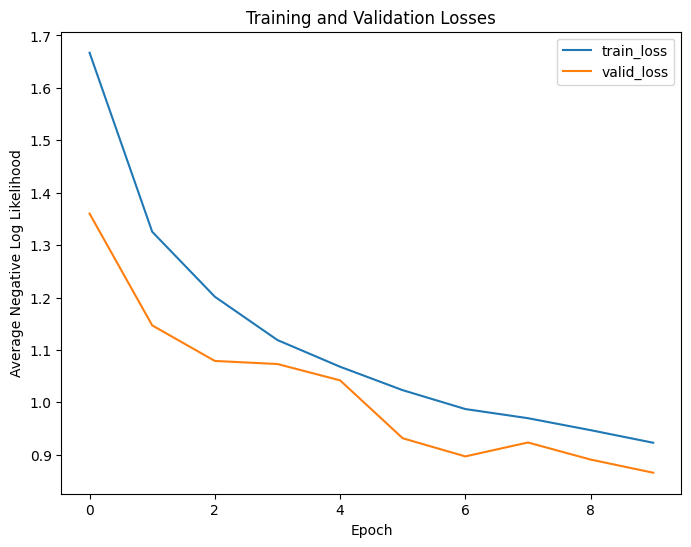

In [87]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

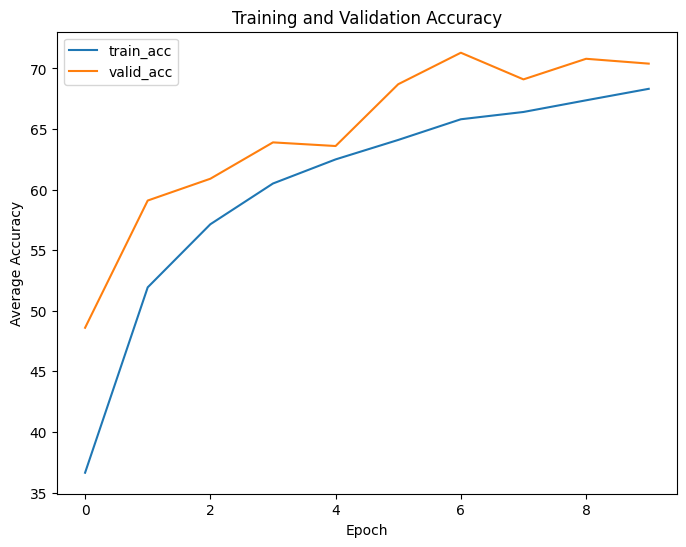

In [88]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

## Model Modifications and Justifications

As part of the CIFAR-10 classification task, it was required to implement, train, and improve a neural network model capable of learning from 32×32 color images. While building and testing the model, I encountered several issues that hindered training convergence or caused runtime errors. Below is a summary of the key modifications made, the problems they addressed, and how they improved the final model:

- **Normalized pixel values from `[0, 255]` → `[0, 1]` → `[-1, 1]`**  
  **Issue fixed:** Model was stuck at ~10% accuracy.  
  **Justification:** Normalization improves numerical stability and gradient flow. This change resulted in the biggest performance boost for the model.

- **Reshaped data from `[B, 32, 32, 3]` → `[B, 3, 32, 32]`**  
  **Issue fixed:** `RuntimeError: Expected 4D input to conv2d, but got [B, 3072]`.  
  **Justification:** PyTorch expects channel-first format for `Conv2d`.

- **Converted label tensors from `.float()` to `.long()`**  
  **Issue fixed:** `RuntimeError: Expected object of scalar type Long, but got Float`.  
  **Justification:** `nn.CrossEntropyLoss` requires targets to be of type `LongTensor`.

- **Redesigned the AlexNet architecture to be CIFAR-10 compatible**  
  **Issue fixed:** Original AlexNet used large filters and stride incompatible with small 32×32 inputs.  
  **Justification:** Replaced 11×11 and 5×5 filters with 3×3, reduced number of filters, and adapted pooling to match the smaller input size. ([source](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html))

- **Used the `Adam` optimizer with `lr=0.001`**  
  **Justification:** Adaptive optimization led to faster convergence and better performance on small datasets like CIFAR-10.

- **Added model saving/loading and early stopping**  
  **Justification:** Prevents overfitting, ensures best-performing weights are retained.

These iterative fixes collectively resolved type mismatches, data formatting issues, and training bottlenecks. After tuning, the final model successfully converged, achieving 70% validation accuracy within 10 epochs. The redesigned architecture and normalized input pipeline proved essential in transforming a non-functional baseline into a stable and high-performing model. During early training runs, the model achieved 23% validation accuracy after just 3 epochs before being stopped early, with a validation loss of 2.09. Total training time for this run was 39.94 seconds, averaging 9.98 seconds per epoch.